**Testing Classification Models**

# Imports

## Libraries

In [272]:
import os
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
import numpy as np
import librosa
import warnings # from https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
from functions import *
import seaborn as sns
import speechpy
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import sklearn
import pickle
import keras
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, Embedding, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
import math

## Dataframe

In [2]:
df = pd.read_csv("combined_corrected_textgrids", index_col= 0)

# Random Forest Using Hampel Filter

For this section, I'll use the Hampel Filter as one of many features used to determine whether a piece of an audio files is a vowel or not. Here are the features I'll use:
- Whether if passes the  Hampel Filter
- The speaker (unclear actually, if the audio was single channel, then yes)
- Each of the MFCC values 

## Making DataFrame for all of corrected textgrid

Making the hampel filter and mfcc features into the same time scale needs to be addressed first. Doing it this way, will give us a feature "passed_hampel_filter" while having other information to draw on.

#### Getting full length audio

In [3]:
long_audio, sr = librosa.load("./original_en_diapix_data/DP_ENF_02_ENF_06_EN_ENF_02_DP_ENF_02_ENF_06_EN_ENF_06.wav", sr = 8000)

### Getting mfcc for whole file

In [555]:
# 40 samples per second
1 / 0.025 

40.0

In [5]:
mfcc_long_audio = speechpy.feature.mfcc(signal = long_audio, sampling_frequency = 8000, frame_length = 0.025, 
                             frame_stride = 0.025)

#### examining output of mfcc

In [7]:
mfcc_long_audio.shape

(21103, 13)

In [8]:
mfcc_long_audio[0]

array([-36.04365339,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

#### Turning into a dataframe
https://stackoverflow.com/questions/20763012/creating-a-pandas-dataframe-from-a-numpy-array-how-do-i-specify-the-index-colum

In [556]:
cols = ['MFCC_'+str(i) for i in range(1, 13+1)]
cols[0:3]

['MFCC_1', 'MFCC_2', 'MFCC_3']

In [11]:
mfcc_df = pd.DataFrame(data = mfcc_long_audio[0:,0:], columns = cols)

In [12]:
mfcc_df.head(2)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# length of the file divided by 40 equals time length of file, i.e.: sampling rate 
len(mfcc_df) / 527.575

40.0

### Adding Hampel Filter to this dataframe

#### Running hampel filter over entire file using same window length as mfcc and low hampel filter value

In [557]:
8000 / 40

200.0

In [15]:
# there are 40 samples per second in the mfcc, which is 200 samples in the hampel filter rate (8000 per second).
# Therefore, we are only looking within one mfcc to see if a sample is passing the hampel filter 

In [16]:
window200_sigma1 = hampel_filter_forloop_numba(long_audio, 200, n_sigmas=1)

In [17]:
len(window200_sigma1[0]) / 8000

527.60425

In [18]:
window200_sigma1_binary = make_results_into_binary(window200_sigma1[1], 
                                                   number_of_possible_samples_in_file = len(window200_sigma1[0]))

In [19]:
# definitely found (what it thinks are) vowels! 
window200_sigma1_binary.sum()

1279737.0

In [558]:
# it guessed that 30% of the file was a vowel (it was found to be closer to 10%)
window200_sigma1_binary.sum() / len(window200_sigma1_binary)

0.30319529268386297

#### Chunking the indices to 200 samples per second 

In [21]:
window200_sigma1_percent_passing = make_sample_rates_match(window200_sigma1[1], 40, 21103)

In [22]:
len(window200_sigma1_percent_passing)

21103

#### Adding the hampel filter percentage to the df

In [23]:
mfcc_df['Percent_passing_hampel_filter'] = window200_sigma1_percent_passing

In [24]:
mfcc_df.head(4)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,Percent_passing_hampel_filter
0,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
mfcc_df['Percent_passing_hampel_filter'].mean()

0.30481542908591197

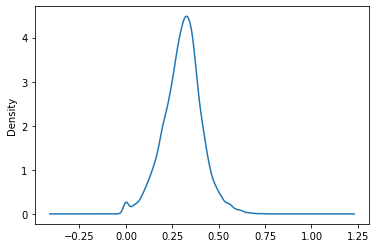

In [26]:
mfcc_df['Percent_passing_hampel_filter'].plot.kde()

#### Saving this dataframe

In [27]:
# mfcc_df.to_csv("./corrected_textgrid/mfcc_hamp_filter_df/df")

### Making prediction column (vowel/not vowel for correct time points)

In [28]:
only_vowels_df = df[df['Vowel']==1].reset_index()

In [29]:
only_vowels_df.head(2)

,index,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
0,2,AH,4.589832,4.831125,!SIL,2.000000,4.361218,1,6,0.241293
1,5,AY,5.481125,5.881125,mine,5.141125,6.111125,1,6,0.400000


In [30]:
#I have to limit the df to vowels either in the function, or before I input the df
vowel_indices = chunk_vowels_to_sr(only_vowels_df)

In [31]:
len(vowel_indices) / 40

25998.875

In [32]:
vowel_indices[0:10]

[36719, 36720, 36721, 36722, 36723, 36724, 36725, 36726, 36727, 36728]

In [33]:
vowel_indices_percent_passing = make_sample_rates_match(vowel_indices, 40, 21103)

In [34]:
sum(vowel_indices_percent_passing)

5206.340000000007

In [560]:
# in reality, 25% of the file is a vowel
sum(vowel_indices_percent_passing) / len(vowel_indices_percent_passing)

0.24671089418566117

#### Make into binary classification (currently a percentage)

##### Trying to find distribution of values in vowel_indices_percent_passing

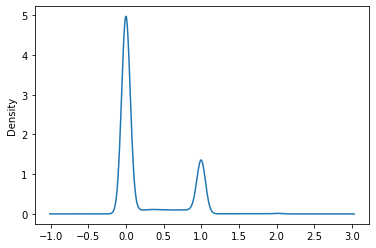

In [36]:
vowel_indices_percent_passing_series = pd.Series(vowel_indices_percent_passing)
ax = vowel_indices_percent_passing_series.plot.kde()

In [37]:
type(vowel_indices_percent_passing)

list

In [38]:
vowel_indices_percent_passing_array = np.array(vowel_indices_percent_passing)

In [39]:
# finding percent of values that are above 0
counter = 0
for x in vowel_indices_percent_passing:
    if x > 0.5:
        counter+=1
counter

5097

In [40]:
vowel_indices_binary = np.where(vowel_indices_percent_passing_array > 0.5, 1, 0)

In [561]:
# percentage slightly goes down because of rounding each vowel into a 1/40th of a second group
vowel_indices_binary.sum() / len(vowel_indices_binary)

0.24152964033549731

### Formally making test/ train split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1)

## Building Random Forest Model

### Model 1

In [44]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [45]:
# initializing the metric dictionary since it hasn't been called yet
metric_dictionary = {} 
metric_dictionary = find_metrics(y_test, rf_pred, metric_dictionary, 'first_random_forest')

      
        The f1 score is 0.728. 

        The recall_score is 0.706. 

        The precision is 0.752. 


In [47]:
metric_dictionary

{'first_random_forest': {'f1_score': 0.728,
  'recall_score': 0.706,
  'precision_score': 0.752}}

### Model 2

In [48]:
# trying more estimators 
rf2 = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs=-1)
rf2.fit(X_train, y_train)
rf_pred2 = rf2.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 

In [49]:
metric_dictionary = find_metrics(y_test, rf_pred2, metric_dictionary, 'second_random_forest')

      
        The f1 score is 0.736. 

        The recall_score is 0.719. 

        The precision is 0.755. 


In [50]:
random_forest_cm2 = confusion_matrix(y_test, rf_pred2)
print(random_forest_cm2)

[[4838  403]
 [ 484 1239]]


### Model 3

In [51]:
# lower level of nodes, class_weight='balanced_subsample'
# trying more estimators 
rf3 = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1,
                            class_weight='balanced_subsample')
rf3.fit(X_train, y_train)
rf_pred3 = rf3.predict(X_test)

In [54]:
metric_dictionary = find_metrics(y_test, rf_pred3, metric_dictionary, 'third_random_forest')

      
        The f1 score is 0.723. 

        The recall_score is 0.685. 

        The precision is 0.764. 


### Model 4

In [55]:
# BalancedRandomForestClassifier 
rf4 = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf4.fit(X_train, y_train)
rf_pred4 = rf4.predict(X_test)

In [432]:
# sorted(sklearn.metrics.SCORERS.keys())
# this method isn't very helpful compare to computing f1 score
# print(cross_val_score(rf4, X_train, y_train, cv=5, scoring='f1'))

In [56]:
metric_dictionary = find_metrics(y_test, rf_pred4, metric_dictionary, 'fourth_random_forest')

      
        The f1 score is 0.734. 

        The recall_score is 0.917. 

        The precision is 0.612. 


### Model 5 - class_weight = 'balanced'

In [57]:
rf5 = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1,
                            class_weight='balanced')
rf5.fit(X_train, y_train)
rf_pred5 = rf5.predict(X_test)

In [58]:
metric_dictionary = find_metrics(y_test, rf_pred5, metric_dictionary, 'fifth_random_forest')

      
        The f1 score is 0.727. 

        The recall_score is 0.694. 

        The precision is 0.764. 


## Bagging algorithms

### Model 1: Base 

In [59]:
bagging_model = BaggingClassifier(n_estimators=100, random_state=42, n_jobs=-1)
bagging_model.fit(X_train, y_train)
bagging_model_predictions = bagging_model.predict(X_test)

In [60]:
metric_dictionary = find_metrics(y_test, bagging_model_predictions, metric_dictionary, 'first_bagged_model')

      
        The f1 score is 0.736. 

        The recall_score is 0.723. 

        The precision is 0.749. 


### Model 2: balanced bagging 

In [61]:
balanced_bagging_model = BalancedBaggingClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
balanced_bagging_model.fit(X_train, y_train)
balanced_bagging_model_predictions = balanced_bagging_model.predict(X_test)

In [62]:
metric_dictionary = find_metrics(y_test, balanced_bagging_model_predictions, metric_dictionary, 'second_bagged_model')

      
        The f1 score is 0.746. 

        The recall_score is 0.867. 

        The precision is 0.654. 


## Ensemble Methods

### Model 1

In [63]:
ensemb_model = EasyEnsembleClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ensemb_model.fit(X_train, y_train)
ensemb_model_predictions = ensemb_model.predict(X_test)

In [64]:
metric_dictionary = find_metrics(y_test, ensemb_model_predictions, metric_dictionary, 'first_ensemble_model')

      
        The f1 score is 0.707. 

        The recall_score is 0.918. 

        The precision is 0.575. 


## Random Forest with SMOTE

In [65]:
oversample3 = SMOTE(sampling_strategy=0.7)

In [66]:
X_train_oversample3, y_train_oversample3 = oversample3.fit_resample(X_train, y_train)

In [67]:
# ratio of 40/60 vowel / nonvowel
y_train_oversample3.sum() / len(y_train_oversample3)

0.41174863387978144

In [68]:
rf_sm = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
rf_sm.fit(X_train_oversample3, y_train_oversample3)
rf_pred_sm = rf_sm.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [69]:
metric_dictionary = find_metrics(y_test, rf_pred_sm, metric_dictionary, 'random_forest_w_smote')

      
        The f1 score is 0.755. 

        The recall_score is 0.81. 

        The precision is 0.708. 


## Picking best model

In [70]:
best_f1 = 0
best_model_list = []
for item in metric_dictionary:
    if metric_dictionary[item]['f1_score'] > best_f1:
        best_f1 = metric_dictionary[item]['f1_score']
        best_model_list.append(item)
print(best_model_list[-1])
print(best_f1)

random_forest_w_smote
0.755


In [73]:
# metric_dictionary

## Improving Best Model

In [201]:
# adding more trees for current best model 
random_forest_w_smote2 = RandomForestClassifier(n_estimators = 1000, random_state = 42, n_jobs=-1)
random_forest_w_smote2.fit(X_train_oversample3, y_train_oversample3)
random_forest_w_smote_predictions2 = random_forest_w_smote2.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [202]:
metric_dictionary = find_metrics(y_test, random_forest_w_smote_predictions2, metric_dictionary, 'random_forest_w_smote2')

      
        The f1 score is 0.761. 

        The recall_score is 0.818. 

        The precision is 0.712. 


# Saving models/data

In [531]:
# with open('./corrected_textgrid/data_for_final_model/vowel_indices', "wb+") as f:
#     pickle.dump(vowel_indices, f)

In [528]:
# test_train_split = "X_train, X_test, y_train, y_test = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1)"
# with open('./corrected_textgrid/data_for_final_model/test_train_split', "wb+") as f:
#     pickle.dump(test_train_split, f)

In [529]:
# best_model_info = """
# balanced_bagging_model2 = BalancedBaggingClassifier(n_estimators = 10000, random_state=42, n_jobs=-1)
# balanced_bagging_model2.fit(X_train, y_train)
# balanced_bagging_model_predictions2 = balanced_bagging_model2.predict(X_test)
# """

In [530]:
# with open('./corrected_textgrid/data_for_final_model/best_model_info', "wb+") as f:
#     pickle.dump(best_model_info, f)

In [ ]:
# why is there such a difference in the size of the two test/train/splits? 
## --- I think it's because I ran it on the new_indices that the hampel filter makes (only median values)
## --- instead of the original data 
# _ I think the answer is that I made a mistake when I was finding the test/validate/train split point

# Neural Networks

## Getting data

In [568]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1)

In [569]:
X_train.shape

(14139, 14)

In [570]:
y_train.shape

(14139,)

## Initializing Model Architecture Used Throughout 

In [571]:
# Initialize a sequential model
model = Sequential()
# Two layers with relu activation 8 layers
model.add(Dense(50, activation='relu', input_shape=(14,)))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(25, activation='tanh'))
model.add(Dense(25, activation='relu'))
# One layer with sigmoid activation 
model.add(Dense(1, activation='sigmoid'))

In [572]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [655]:
es = EarlyStopping(monitor = 'acc', mode = 'auto', patience = 3, min_delta = 0.01)
mcp = ModelCheckpoint('history', monitor= 'acc', mode = 'auto', save_best_only=True)

## Vanilla Neural Networks

### Model 1 - no upsample

In [656]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcp])

Epoch 1/75
14139/14139 [==============================] - 0s 30us/step - loss: 0.2324 - acc: 0.8958
Epoch 2/75
14139/14139 [==============================] - 0s 30us/step - loss: 0.2280 - acc: 0.9001
Epoch 3/75
14139/14139 [==============================] - 0s 30us/step - loss: 0.2284 - acc: 0.8968
Epoch 4/75
14139/14139 [==============================] - 0s 32us/step - loss: 0.2270 - acc: 0.8991


In [628]:
#history
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

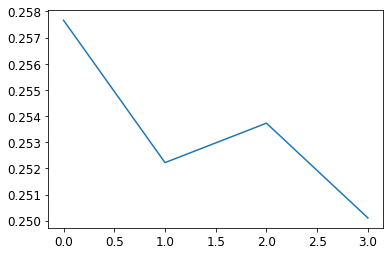

In [629]:
# Plot the loss vs the number of epoch
sns.lineplot(x = range(len(history_dict['loss'])), y=history_dict['loss'])

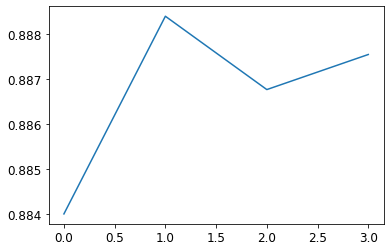

In [630]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict['acc'])), y=history_dict['acc'])

In [631]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(X_test)

In [634]:
ynew = model.predict_classes(X_test)
print(classification_report(y_test, ynew))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      5241
           1       0.74      0.71      0.72      1723

    accuracy                           0.87      6964
   macro avg       0.82      0.81      0.82      6964
weighted avg       0.87      0.87      0.87      6964



In [635]:
model_confusionmatrix = confusion_matrix(y_test, ynew)
model_confusionmatrix

array([[4821,  420],
       [ 505, 1218]])

In [636]:
metric_dictionary = find_metrics(y_test, ynew, metric_dictionary, 'first_vanilla_network')

      
        The f1 score is 0.725. 

        The recall_score is 0.707. 

        The precision is 0.744. 


### Model 2 - class weighting

#### What are the proportion of non-vowels to vowels

In [637]:
# approximately a 1:4 ratio
len(y_test) / y_test.sum()

4.04178757980267

#### Class weight dictionary to add to the model

In [638]:
# making the values the inverse of the proportion so that vowels are weighted more strongly
weights = {0:1, 1:4}

#### The model

In [657]:
history2 = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcp],
                    class_weight=weights)

Epoch 1/75
14139/14139 [==============================] - 0s 30us/step - loss: 0.4677 - acc: 0.8591
Epoch 2/75
14139/14139 [==============================] - 0s 31us/step - loss: 0.4616 - acc: 0.8578
Epoch 3/75
14139/14139 [==============================] - 0s 29us/step - loss: 0.4636 - acc: 0.8559
Epoch 4/75
14139/14139 [==============================] - 0s 29us/step - loss: 0.4518 - acc: 0.8617


In [652]:
#history
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'acc'])

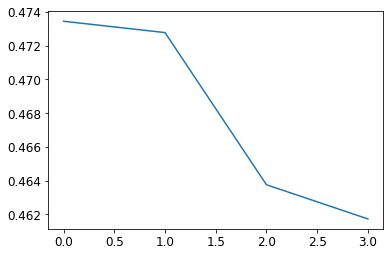

In [653]:
# Plot the loss vs the number of epoch
sns.lineplot(x = range(len(history_dict2['loss'])), y=history_dict2['loss'])

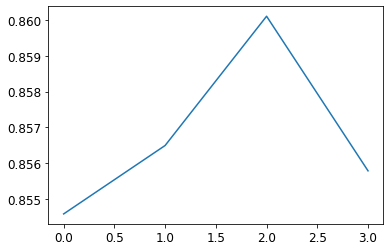

In [654]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict2['acc'])), y=history_dict2['acc'])

In [644]:
# Output (probability) predictions for the test set 
y_hat_test2 = model.predict(X_test)

In [645]:
ynew2 = model.predict_classes(X_test)
print(classification_report(y_test, ynew2))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      5241
           1       0.62      0.88      0.73      1723

    accuracy                           0.84      6964
   macro avg       0.79      0.85      0.81      6964
weighted avg       0.87      0.84      0.85      6964



In [646]:
model_confusionmatrix2 = confusion_matrix(y_test, ynew2)
model_confusionmatrix2

array([[4317,  924],
       [ 199, 1524]])

In [647]:
# no difference from first model
metric_dictionary = find_metrics(y_test, ynew2, metric_dictionary, 'second_vanilla_network')

      
        The f1 score is 0.731. 

        The recall_score is 0.885. 

        The precision is 0.623. 


## Upsampling Vowels

In [139]:
# upsampling on the training data 
oversample = SMOTE()
X_train_oversample, y_train_oversample = oversample.fit_resample(X_train, y_train)

In [140]:
len(X_train_oversample)

21530

In [141]:
len(X_train)

14139

### Model 3

In [658]:
history3 = model.fit(X_train_oversample, y_train_oversample,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcp])

Epoch 1/75
21530/21530 [==============================] - 1s 31us/step - loss: 0.2523 - acc: 0.8969
Epoch 2/75
21530/21530 [==============================] - 1s 31us/step - loss: 0.2488 - acc: 0.8977
Epoch 3/75
21530/21530 [==============================] - 1s 28us/step - loss: 0.2457 - acc: 0.9001
Epoch 4/75
21530/21530 [==============================] - 1s 29us/step - loss: 0.2457 - acc: 0.8991


In [659]:
#history
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'acc'])

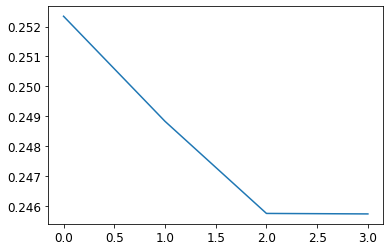

In [660]:
# Plot the loss vs the number of epoch
sns.lineplot(x = range(len(history_dict3['loss'])), y=history_dict3['loss'])

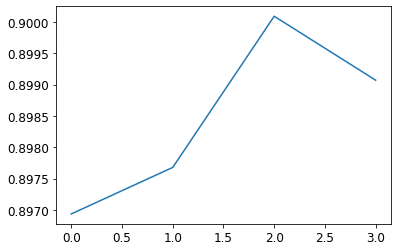

In [661]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict3['acc'])), y=history_dict3['acc'])

In [662]:
# Output (probability) predictions for the test set 
y_hat_test3 = model.predict(X_test)

In [663]:
ynew3 = model.predict_classes(X_test)
print(classification_report(y_test, ynew3))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      5241
           1       0.63      0.87      0.73      1723

    accuracy                           0.84      6964
   macro avg       0.79      0.85      0.81      6964
weighted avg       0.87      0.84      0.85      6964



In [664]:
model_confusionmatrix3 = confusion_matrix(y_test, ynew3)
model_confusionmatrix3

array([[4364,  877],
       [ 223, 1500]])

In [665]:
# wow! this works amazingly well! 
metric_dictionary = find_metrics(y_test, ynew3, metric_dictionary, 'vanilla_network_w_upsample')

      
        The f1 score is 0.732. 

        The recall_score is 0.871. 

        The precision is 0.631. 


## Upsampling with Undersampling Examples 

In [176]:
# changing the training samples, not the test samples
oversample2 = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.7)

In [177]:
X_train_over2, y_train_over2 = oversample2.fit_resample(X_train, y_train)

In [178]:
X_train_under_over, y_train_under_over = under.fit_resample(X_train_over2, y_train_over2)

In [179]:
len(X_train)

14139

In [180]:
len(X_train_over2)

17224

In [181]:
len(X_train_under_over)

15686

#### Getting ratio between the two classes now

In [182]:
y_train_under_over.sum() / len(y_train_under_over)

0.4117684559479791

Now we have a 40/60 split of vowels to non-vowels

### Model 4

In [666]:
history4 = model.fit(X_train_under_over, y_train_under_over,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcp])

Epoch 1/75
15686/15686 [==============================] - 1s 32us/step - loss: 0.2505 - acc: 0.8932
Epoch 2/75
15686/15686 [==============================] - 0s 28us/step - loss: 0.2483 - acc: 0.8961
Epoch 3/75
15686/15686 [==============================] - 0s 28us/step - loss: 0.2551 - acc: 0.8896
Epoch 4/75
15686/15686 [==============================] - 0s 28us/step - loss: 0.2477 - acc: 0.8967


In [667]:
#history
history_dict4 = history4.history
history_dict4.keys()

dict_keys(['loss', 'acc'])

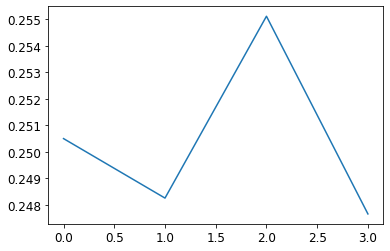

In [668]:
# Plot the loss vs the number of epoch
sns.lineplot(x = range(len(history_dict4['loss'])), y=history_dict4['loss'])

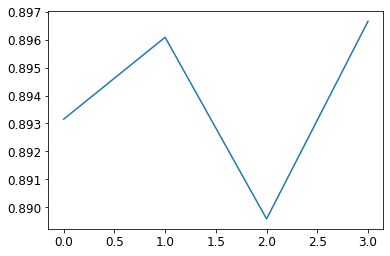

In [669]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict4['acc'])), y=history_dict4['acc'])

In [670]:
# Output (probability) predictions for the test set 
y_hat_test4 = model.predict(X_test)

In [671]:
ynew4 = model.predict_classes(X_test)
print(classification_report(y_test, ynew4))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5241
           1       0.66      0.83      0.73      1723

    accuracy                           0.85      6964
   macro avg       0.80      0.84      0.82      6964
weighted avg       0.87      0.85      0.86      6964



In [672]:
model_confusionmatrix4 = confusion_matrix(y_test, ynew4)
model_confusionmatrix4

array([[4486,  755],
       [ 286, 1437]])

In [673]:
# similar though slightly better results than just upsampling
metric_dictionary = find_metrics(y_test, ynew4, metric_dictionary, 'vanilla_network_w_upsample_and_downsample')

      
        The f1 score is 0.734. 

        The recall_score is 0.834. 

        The precision is 0.656. 


## Choosing Best Model

In [674]:
best_f1 = 0
best_model_list = []
for item in metric_dictionary:
    if metric_dictionary[item]['f1_score'] > best_f1:
        best_f1 = metric_dictionary[item]['f1_score']
        best_model_list.append(item)
print(best_model_list[-1])
print(best_f1)

random_forest_w_smote2
0.761


# Conclusion about Classification Models

My best model is a random forest that upsamples data with SMOTE. It has an F1 score of 0.761. The neural networks were also improve by using SMOTE. 

In [675]:
metric_dictionary

{'first_random_forest': {'f1_score': 0.728,
  'recall_score': 0.706,
  'precision_score': 0.752},
 'second_random_forest': {'f1_score': 0.736,
  'recall_score': 0.719,
  'precision_score': 0.755},
 'third_random_forest': {'f1_score': 0.723,
  'recall_score': 0.685,
  'precision_score': 0.764},
 'fourth_random_forest': {'f1_score': 0.734,
  'recall_score': 0.917,
  'precision_score': 0.612},
 'fifth_random_forest': {'f1_score': 0.727,
  'recall_score': 0.694,
  'precision_score': 0.764},
 'first_bagged_model': {'f1_score': 0.736,
  'recall_score': 0.723,
  'precision_score': 0.749},
 'second_bagged_model': {'f1_score': 0.746,
  'recall_score': 0.867,
  'precision_score': 0.654},
 'first_ensemble_model': {'f1_score': 0.707,
  'recall_score': 0.918,
  'precision_score': 0.575},
 'random_forest_w_smote': {'f1_score': 0.755,
  'recall_score': 0.81,
  'precision_score': 0.708},
 'random_forest_w_smote2': {'f1_score': 0.761,
  'recall_score': 0.818,
  'precision_score': 0.712},
 'first_vanill

# Analyzing Results 

- So all of these models were analyzing the individual frames (1/200th of a second) in a random order (therefore, without surrounding context). Vowels in the real world appear as a 25-150 millisecond continuous collection of sounds. Therefore, the frames are somewhat unnatural in terms of making a singular prediction of vowel or not vowel. 
- Here, I'll analyze the predictions of my models to see if my models:
    - make at least one correct prediction over the course of a vowel
    - what are the tendencies of the incorrect predictions: are they sounds similar to vowels?
- Since it will be near impossible to place the upsampled/downsampled predictions in the original order (as far as I am aware), I will work with the best model that does not upsample/downsample: the second bagged model

## Rerunning the model without a shuffled test/train split

In [677]:
#original test train split was done with this code
X_train2, X_test2, y_train2, y_test2 = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1, shuffle=False)

### Rerunning the model

In [679]:
balanced_bagging_model2 = BalancedBaggingClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
balanced_bagging_model2.fit(X_train2, y_train2)
balanced_bagging_model_predictions2 = balanced_bagging_model2.predict(X_test2)

In [688]:
metric_dictionary = find_metrics(y_test2, balanced_bagging_model_predictions2, metric_dictionary, 'second_bagged_model_different_split')

      
        The f1 score is 0.725. 

        The recall_score is 0.781. 

        The precision is 0.676. 


## Bringing together the x_test2, y_test2 for the second bagged model

In [683]:
original_df_last_third = X_test2.copy()

In [684]:
original_df_last_third['actual_vowels'] = y_test2
original_df_last_third['predicted_vowels'] = balanced_bagging_model_predictions2

In [307]:
original_df_last_third.head(2)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,Percent_passing_hampel_filter,actual_vowels,predicted_vowels
14139,-10.098527,4.932286,1.864990,0.316451,-0.312592,-0.995565,-1.099944,-0.379565,-1.390550,-1.055092,0.202184,-0.167304,0.749360,0.08,0,0
14140,-8.468687,12.740945,4.570114,0.603386,-2.683702,-3.259884,-2.459758,-1.270219,0.625708,-0.024474,0.125958,-0.629837,-0.060484,0.37,0,0


### How many vowels were predicted in each column?

In [227]:
original_df_last_third['actual_vowels'].sum()

1554

In [228]:
original_df_last_third['predicted_vowels'].sum()

1796

In [689]:
df.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
0,NaN,0.0,2.000000,NaN,0.0,2.000000,0,6,2.000000
1,!SIL,2.0,4.589832,!SIL,2.0,4.361218,0,6,2.589832


In [238]:
# first step: finding which section of the df is where the test data starts
# length of file * 0.67 will be beginning time point for test section
beginning_time_point_test = (len(long_audio) / 8000) * 0.67
beginning_time_point_test

353.4948475

In [514]:
test_df = df[df['Phone_xmin'] > beginning_time_point_test].copy()

In [515]:
test_df.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
1394,AH,353.988485,354.071,!SIL,343.027075,353.951077,1,6,0.082515
1395,P,354.071000,354.211,!SIL,343.027075,353.951077,0,6,0.140000


In [516]:
# test_df covers 174 seconds
(len(long_audio) / 8000) - beginning_time_point_test

174.1094025

#### Finding correct vowel chunks

In [517]:
phone_xmin_array = np.array(test_df['Phone_xmin'])
first_full_phone_in_test_df = phone_xmin_array.min()
first_full_phone_in_test_df

353.98848519748657

In [518]:
first_full_phone_remainder = first_full_phone_in_test_df % 0.025

In [519]:
first_full_phone_remainder

0.013485197486548618

In [520]:
first_full_phone_chunk = first_full_phone_in_test_df - first_full_phone_remainder
first_full_phone_chunk

353.975

In [521]:
# I should get all of the chunks after 14159
first_full_phone_chunk / 0.025

14159.0

In [522]:
# mfcc covers 0.025 seconds of audio 
beg_chunk_remainder = beginning_time_point_test % 0.025

In [523]:
start_interval_of_test_df = beginning_time_point_test - beg_chunk_remainder
start_interval_of_test_df

353.475

In [524]:
start_interval_of_test_df / 0.025

14139.0

#### Getting total number of possible vowels to be predicted in each chunk

In [525]:
test_df['Total_frames_in_phone'] = test_df['Phone_Duration'] * 40

In [526]:
test_df.tail(4)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Total_frames_in_phone
3414,EY,520.726125,520.886125,!SIL,518.455909,520.326117,1,2,0.160000,6.400000
3415,lg,520.886125,521.407062,<LG>,520.886125,521.407062,0,2,0.520937,20.837500
3416,!SIL,521.407062,525.604172,!SIL,521.407062,525.604172,0,2,4.197110,167.884394
3417,!SIL,525.604172,527.604172,!SIL,525.604172,527.604172,0,2,2.000000,80.000000


In [527]:
test_df.reset_index(inplace=True)

In [528]:
(first_full_phone_chunk * 8000) / len(long_audio) 

0.6709100618503357

In [529]:
(first_full_phone_chunk * 8000) * 0.025

70795.0

In [530]:
first_full_phone_chunk

353.975

Let's recap. I want to see how many predicted vowels are actually in each vowel
- so I should probably keep the test_df as is, and then chunk the predictions into the time intervals of the phones


In [686]:
return_list = []
split_point = int(len(mfcc_df) * 0.67)
y_test2_indices = [((idx + split_point) * 0.025) for idx, x in enumerate(y_test2)]
predictions_in_seconds = np.array(y_test2_indices)

In [532]:
predictions_in_seconds

array([353.475, 353.5  , 353.525, ..., 527.5  , 527.525, 527.55 ])

In [687]:
predictions_and_time_in_seconds = list(zip(y_test2, y_test2_indices))

In [534]:
predictions_and_time_in_seconds[0:5]

[(0, 353.475),
 (0, 353.5),
 (0, 353.52500000000003),
 (0, 353.55),
 (0, 353.57500000000005)]

In [535]:
predictions_and_time_in_seconds[0][1]

353.475

In [536]:
pos_prediction_list = []
for x in range(test_df.shape[0]):
    time_range = [test_df['Phone_xmin'][x], test_df['Phone_xmax'][x]]
    total_pos_predictions = 0
    for y in predictions_and_time_in_seconds:
        if time_range[0] <= y[1] < time_range[1]:
            if y[0] == 1:
                total_pos_predictions += 1
    pos_prediction_list.append(total_pos_predictions)

In [537]:
len(pos_prediction_list)

1031

In [538]:
test_df['positive_predictions'] = pos_prediction_list

In [539]:
test_df.head(2)

,index,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Total_frames_in_phone,positive_predictions
0,1394,AH,353.988485,354.071,!SIL,343.027075,353.951077,1,6,0.082515,3.300592,3
1,1395,P,354.071000,354.211,!SIL,343.027075,353.951077,0,6,0.140000,5.600000,1


In [540]:
# rounding the total possible frames because that's how many were presented to my model
test_df['percent_positive_predictions'] = (test_df['positive_predictions'] / (round(test_df['Total_frames_in_phone']))) * 100

In [548]:
test_df.head(3)

,index,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Total_frames_in_phone,positive_predictions,percent_positive_predictions
0,1394,AH,353.988485,354.071,!SIL,343.027075,353.951077,1,6,0.082515,3.300592,3,100.000000
1,1395,P,354.071000,354.211,!SIL,343.027075,353.951077,0,6,0.140000,5.600000,1,16.666667
2,1396,AXR,354.211000,354.271,!SIL,343.027075,353.951077,1,6,0.060000,2.400000,2,100.000000


#### Understanding predictions and whether vowel was actually present

In [542]:
true_vowel = test_df[test_df['Vowel'] == 1]

In [543]:
true_vowel['percent_positive_predictions'].mean()

84.31560345615311

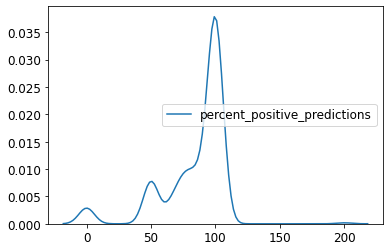

In [544]:
sns.kdeplot(true_vowel['percent_positive_predictions'])

In [545]:
not_true_vowel = test_df[test_df['Vowel'] == 0]

In [546]:
not_true_vowel['percent_positive_predictions'].mean()

18.27575848850993

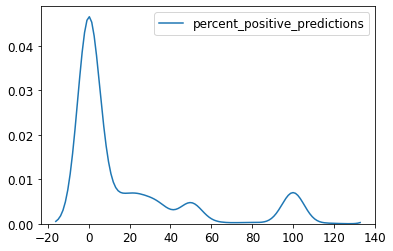

In [547]:
sns.kdeplot(not_true_vowel['percent_positive_predictions'])

### Did speaker have an effect on the predictions?

In [549]:
true_vowel.groupby(['Speaker']).percent_positive_predictions.mean()

Speaker
2    81.378064
6    85.820789
Name: percent_positive_predictions, dtype: float64

In [550]:
not_true_vowel.groupby(['Speaker']).percent_positive_predictions.mean()

Speaker
2    19.379577
6    17.648352
Name: percent_positive_predictions, dtype: float64

Looks to be about the same for each (female) speaker. Perhaps slightly better for speaker 6 than speaker 2

## Conclusion after post-hoc analysis

This bagged model did pretty well at **not** selecting vowels, but was not very good at selecting all of the frames of the actual vowels. On average, it selected only 84% of the actual vowel frames as vowels, while selecting 18% of non-vowels as vowels. However, it was great to see that there is a clear difference between vowels and non-vowels in the two cases. If it was possible to chunk the predictions into clusters, we could significantly improve the model. 
- By having a pre-segmented data set, the model could be expected to do quite well.